In [1]:
import medspacy
from IPython.display import Image

In [2]:
from medspacy.visualization import visualize_dep, visualize_ent, MedspaCyVisualizerWidget
from medspacy.context import ConTextItem
from medspacy.ner import TargetRule

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import seaborn as sns
sns.set()

# Homework: Clinical Information Extraction
Over the last two weeks, you've been introduced to a number of tools for extracting information from clinical text:
- A rule-based matcher using the `TargetMatcher` class
- A pre-trained statistical `NER` model for extracting **"PROBLEM"**, **"TREATMENT"**, and **"TEST"** entities
- `ConTextComponent` for extracting contextual information such as negation, uncertainty, and family history

For your homework assignment, we'll put it all together, improve our model, and deploy it on MIMIC data. Here is an outline of this assignment:

- Build an medspaCy model which includes the `TargetMatcher`, statistical `NER`, and `ConTextComponent`
- Load a sample of discharge summaries from MIMIC
- Review the output of your NLP model on a small number of datasets and make imnprovements by adding patterns or ConTextItems
- Deploy your NLP model on the entire dataset and convert it to structured data
- Analyze the classes and spans of text extracted by your model

As usual, let me know on Slack or Canvas if you have any questions or issues. Let's get started!

# I. Build your model
We'll create a new model by loading the various pieces which we have.

### TODO
Load a clinical `nlp` model using spacy.

In [5]:
nlp = medspacy.load("en_info_3700_i2b2_2012", 
                    enable=["sentencizer", "target_matcher", "context", "sectionizer"]
                   )

/Users/alecchapman/opt/anaconda3/envs/uvu38/lib/python3.8/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_info_3700_i2b2_2012' (0.1.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/Users/alecchapman/opt/anaconda3/envs/uvu38/lib/python3.8/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_info_3700_i2b2_2012' (0.1.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Here are the two components that we will customize:

In [6]:
target_matcher = nlp.get_pipe("target_matcher")

In [7]:
context = nlp.get_pipe("context")

# II. Get Discharge Summaries MIMIC Data
A **discharge summary** is written at the end of a patient's stay in the hospital. It typically contains a summary of the patient, the diagnoses for which they were admitted, and the treatment that they received during their stay. The rich content of these documents makes them an excellent candidate for processing with NLP.

Clinical documents are stored in MIMIC in the table `noteevents`. We will query a number of notes from this table and limit them to discharge summaries through the **"category"** column. We'll just look at 100 notes for now, but if you'd like to increase the number later to get a larger sample size you can.

In [8]:
import pandas as pd
import pymysql
import getpass

In [9]:
# Change to your username
username = "uvu10919523"

conn = pymysql.connect(host="35.233.174.193",port=3306,
                       user=username,passwd=getpass.getpass("Enter password for MIMIC2 database"),
                       db='mimic2')

Enter password for MIMIC2 database········


In [10]:
query = """
SELECT subject_id, text
FROM noteevents
WHERE category = 'DISCHARGE_SUMMARY'
LIMIT 100
"""
df = pd.read_sql(query, conn)

In [11]:
df.head()

,subject_id,text
0,56,\n \n \n \nAdmission Date: [**2644-1-17**] ...
1,37,\n\n\nAdmission Date: [**3264-8-14**] Dis...
2,78,\n\nAdmission Date: [**2778-3-24**] Dis...
3,26,\n\nAdmission Date: [**3079-3-3**] Discha...
4,12,\n\n\nAdmission Date: [**2875-9-26**] Dis...


# 3. Process some texts and review the output
Next, we'll process the discharge summaries and review what our system extracts. Processing full notes is a computationally expensive process, so we'll start by looking at just a few texts before processing the entire batch later.

In [12]:
%%time
texts = df["text"].iloc[:5] # Small sample to start with
docs = list(nlp.pipe(texts))

CPU times: user 6.45 s, sys: 233 ms, total: 6.68 s
Wall time: 6.73 s


In [13]:
from medspacy.visualization import visualize_ent, visualize_dep
from medspacy.visualization import MedspaCyVisualizerWidget

In [14]:
w = MedspaCyVisualizerWidget(docs)

Box(children=(HBox(children=(RadioButtons(options=('Ent', 'Dep', 'Both'), value='Ent'), Button(description='Pr…

In [15]:
# idx = 0
# visualize_ent(docs[idx])

## Optional: Improve your model
As we've seen, our default model is not going to be perfect. If you'd like to spend some time improving your model, go through a few docs above and find mistakes. Then fix them using the methods we saw in previous notebooks.

- **False negatives**: Missing a target entity. This will happen when you see a clinical problem, treatment or test in the text that is not highlighted. You can fix this by **adding patterns** to the `ruler`
- **False positives**: Spans of text which are highlighted but should not be. These are harder to fix. You could write rules to remove an entity from `doc.ents`, but this is a little tricky and difficult to generalize
- **Missing modifiers**: ConText modifiers, such as **"NEGATED_EXISTENCE"** will be highlighted in the text as well. If you see one that is missing, add it to ConText by creating a new `ConTextItem`. You can also visualize what targets the modifiers are applied to by using the `visualize_dep` function.
    - **A note about `visualize_dep`**: This function works best on a *single* sentence rather than an entire doc. So instead of calling `visualize_dep(doc)`, manually add some text, process it with the nlp, and then view the output by calling:  `visualize_dep(nlp("..."))`
    
Edit the cells below to add `TargetRules` and `ConTextItems` to fix mistakes you find in the texts.

In [16]:
from medspacy.ner import TargetRule
from medspacy.context import ConTextItem

In [17]:
target_matcher = nlp.get_pipe("target_matcher")

target_rules = [
    # TargetRule(...),
]

In [18]:
context = nlp.get_pipe("context")

context_rules = [
    # ConTextItem(...)
]

Once you've added new rules, go back to the cells at the beginning of this section, reprocess your docs, and reload your visualizer.

### Now go back, reprocess the doc, and see if your changes worked!

# 4. Deploy your model and convert text to structured data
Now that you've fine-tuned and improved your model, we're ready to run it on the entire dataset and analyze it! In this step, we'll show how you can use NLP to convert text to **structured** data, which you can then analyze in the same way that we previously analyzed structured EHR data like **labs** and **vitals**. We'll now extract all of the entities from our docs and write them to a sqlite database.

The function below will take your DataFrame, process all of the texts with your NLP model, and write the results to a file called `"nlp.db"`. 

In [19]:
from helpers import write_nlp_db

In [20]:
# This may take up to 2-3 minutes
write_nlp_db(nlp, df)

Processing 100 texts
Processed 100 docs in 0:01:23.915670 seconds
Opened connection to None.None
Created table ents with query: CREATE TABLE ents (text varchar(50), start_char int, end_char int, label_ varchar(50), is_negated int, is_uncertain int, is_historical int, is_hypothetical int, is_family int, section_category int, section_parent int)
Wrote 110 rows with query: INSERT INTO ents (text, start_char, end_char, label_, is_negated, is_uncertain, is_historical, is_hypothetical, is_family, section_category, section_parent) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
Wrote 268 rows with query: INSERT INTO ents (text, start_char, end_char, label_, is_negated, is_uncertain, is_historical, is_hypothetical, is_family, section_category, section_parent) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
Wrote 559 rows with query: INSERT INTO ents (text, start_char, end_char, label_, is_negated, is_uncertain, is_historical, is_hypothetical, is_family, section_category, section_parent) VALUES (?, ?, ?, ?, 

We can now connect to this local database using `sqlite3` and treat it like any other structured data. All of our data was written to a table called `ents`. We'll first load all of the results as a pandas dataframe, and in the next section we'll write queries to answer specific questions to explore the NLP-extracted data.

In [21]:
import sqlite3
nlp_conn = sqlite3.connect("nlp.db")

In [22]:
query = """SELECT * FROM ents"""

In [23]:
ents_df = pd.read_sql(query, nlp_conn)

Take a look at the DataFrame below. What does each row correspond to? What do the various columns mean?

In [24]:
ents_df.head()

,text,start_char,end_char,label_,is_negated,is_uncertain,is_historical,is_hypothetical,is_family,section_category,section_parent
0,Known Allergies,206,221,PROBLEM,1,0,0,0,0,allergies,None
1,Drugs,225,230,TREATMENT,1,0,0,0,0,allergies,None
2,Invasive Procedure,314,332,TREATMENT,0,0,0,0,0,chief_complaint,None
3,Age,422,425,TREATMENT,0,0,0,0,0,history_of_present_illness,None
4,lung ca,451,458,PROBLEM,0,0,1,0,0,history_of_present_illness,None


In [25]:
len(ents_df)

16957

In [26]:
ents_df.columns

Index(['text', 'start_char', 'end_char', 'label_', 'is_negated',
       'is_uncertain', 'is_historical', 'is_hypothetical', 'is_family',
       'section_category', 'section_parent'],
      dtype='object')

# 5. Analysis
Now, we can analyze our extracted dataset using SQL, pandas, and matplotlib, just like we did with MIMIC data in the past. As a reminder, you can run queries by passing them into `pd.read_sql` along with our connection object, which in this case is `nlp_conn`.

The table you will be querying is called `ents`.

Go through each of the sections below and analyze the data to answer the question. You can either write queries to directly get numbers (ie, `SELECT ... FROM ents`), or use the DataFrame we created above, `ents_df`, to just run the analyses in pandas.

If you need a reminder of how to use SQL/pandas, you can refer to the notebooks in [../week_6_clinical_data](../week_6_clinical_data) and [../week_7_terminologies](../week_7_terminologies).

## I. Label distribution
- Find the counts of **problems**, **treatments**, and **tests** which were extracted from our corpus 
- Plot the count of entity labels in the dataset using a bar graph

In [44]:
query = """
SELECT 
    label_
    ,COUNT(1)
FROM ents
GROUP BY label_
"""

In [45]:
labels = pd.read_sql(query, nlp_conn)

In [46]:
labels

,label_,COUNT(1)
0,PROBLEM,7595
1,TEST,3667
2,TREATMENT,5695


<AxesSubplot:xlabel='label_', ylabel='COUNT(1)'>

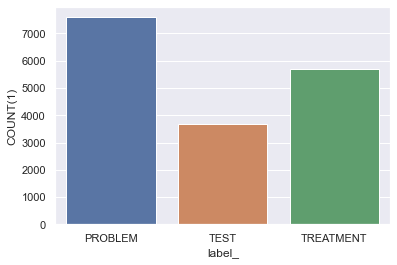

In [58]:
sns.barplot(x="label_", y="COUNT(1)", data=labels)

## II. Treatment texts
Let's see what treatments are being used in these patient visits.
- Find the 10 most common `"text"` values for **"TREATMENT"** entities
- Plot a horizontal bar graph of the texts and counts. (Horizontal because that will make the labels easier to read)
- Do any of these "treatments" look like NLP mistakes?

In [32]:
query = """
SELECT
    text
    ,COUNT(1)
FROM ents
WHERE label_ = 'TREATMENT'
GROUP BY text
ORDER BY COUNT(1) desc
LIMIT 10
"""

In [33]:
treatments = pd.read_sql(query, nlp_conn) 
treatments.head()

,text,COUNT(1)
0,NamePattern1,176
1,Name Pattern1,77
2,Lasix,57
3,Invasive Procedure,48
4,Aspirin,47


<AxesSubplot:xlabel='COUNT(1)', ylabel='text'>

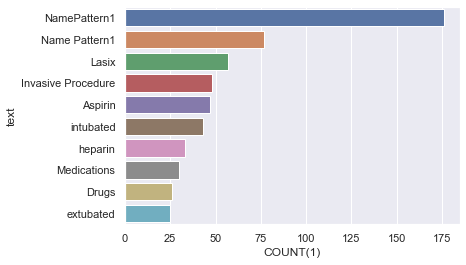

In [ ]:
sns.barplot("text", "COUNT(1)", data=labels)

## III. Problems relevant to a visit
As we saw in the previous notebook, many of the conditions mentioned in a document were not actually experienced by a patient during the hospital stay. That is why we ran **context** to generate the attributes such as **is_negated**. Let's now look at all problems in the dataset which are **relevant** to the dataset, meaning that all of the context attributes are `False` (ie., the problem is **not** historical, **not** negated, etc.)

- Write a query which gets all **"PROBLEM"** entities from the database where all of the following columns are **0**:
    - `is_negated`
    - `is_historical`
    - `is_uncertain`
    - `is_family`
    - `is_hypothetical`
- Group them by **"text"** and find the 10 most common **"text"** spans
- Plot a horizontal bar plot showing the counts

In [51]:
query = """
SELECT 
    text
    ,COUNT(1)
FROM ents
WHERE
    label_ = 'PROBLEM'
    AND is_negated = 0
    AND is_historical = 0
    AND is_uncertain = 0
    AND is_family = 0
    AND is_hypothetical = 0
GROUP BY text
ORDER BY COUNT(1) desc
LIMIT 10
"""

In [52]:
relv_problems = pd.read_sql(query, nlp_conn)

In [53]:
relv_problems.head()

,text,COUNT(1)
0,NamePattern2,89
1,afebrile,52
2,Hypertension,44
3,CAD,35
4,HTN,34


<AxesSubplot:xlabel='COUNT(1)', ylabel='text'>

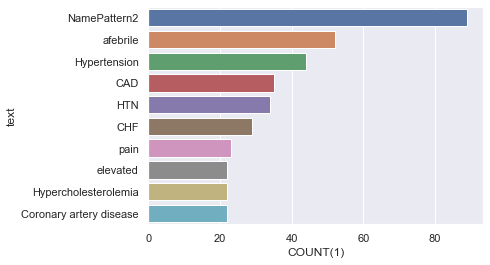

In [57]:
sns.barplot(y="text", x="COUNT(1)", data=relv_problems)

## IV. Patient family history
In addition to **excluding** conditions which are not experienced by a patient, context can also help us target conditions which occurred in a patient's family history. While these conditions may not directly affect a patient, they are important to a patient's health because they might suffer from a heightened risk for this condition or other complications.

In medspaCy, we can detect this by using the `is_family` attribute, or by seeing that an entity occurred in the `family_history` section of a note, which is shown by the `section_category` attribute. 

Let's now find patients with family history of cancer and see what types of cancer they have.

### TODO
- Write a query to get rows where:
    - `label_` is **"PROBLEM"**
    - `is_family` = **1** **OR** section_category = 'family_history'
- Find the 10 most common text spans and plot them with a horizontal bar plot

In [40]:
query = """
SELECT text
    ,COUNT(1)
FROM ents
WHERE label_ = 'PROBLEM'
    AND is_family = 1
    OR section_category = 'family_history'
GROUP BY text
ORDER BY COUNT(1) desc
LIMIT 10
"""

In [41]:
fh = pd.read_sql(query, nlp_conn)

In [42]:
fh.head()

,text,COUNT(1)
0,MI,7
1,CAD,7
2,elevated,6
3,depression,6
4,NI,6


<AxesSubplot:xlabel='COUNT(1)', ylabel='text'>

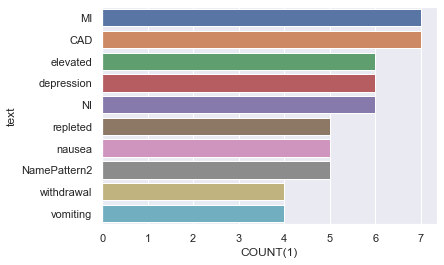

In [43]:
sns.barplot(y="text", x="COUNT(1)", data=fh)